<a href="https://colab.research.google.com/github/eunseochu/OB_4th/blob/main/Customers_clustering_K_Means%2C_DBSCAN_and_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customers clustering: K-Means, DBSCAN and AP**

### **1. Introduction**

**main task of clustering** <br/>
to discover natural groups within an u**nlabelled dataset** (an unsuprvised ML task)
- customers segmentation (for efficient marketing)
- image segmentation
- documents clusterisation.

**clustering algorithms** <br/>
there are many clustering algorithms which can be divided into two main types
- **Hierarchical algorithms**
  - recursively split a dataset into a smaller subset until a subset contains only one item
  - represented with a dendrogram which looks like a tree
  - can be constructed from leaves to the roo or from the root down to the leaves
  - don’t have to specify the number of clusters
  - have to define a termination condition for splitting/merging process
- **Partitional algorithms**
  - divide a dataset into several subsets (clusters) based on a given criteria
  - number of clusters has to be defined a priori (e.g K-Means) and for some not (DBSCAN)
  - Defining the number of clusters before running an algorithm often requires <br/> a specific domain knowledge which is often challenging (or even impossible) 
  -  many heuristics and simplified approaches to choose the appropriate number of clusters

### **2. Reading data**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.4.4
numpy version: 1.22.4
seaborn version: 0.12.2


In [3]:
mall_data = pd.read_csv('/content/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [4]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
71,72,Female,47,49,42
102,103,Male,67,62,59
118,119,Female,51,67,43
110,111,Male,65,63,52
196,197,Female,45,126,28
93,94,Female,40,60,40
88,89,Female,34,58,60
168,169,Female,36,87,27
47,48,Female,27,40,47
36,37,Female,42,34,17


In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**5 columns** <br/>
- **Customer ID**
  - numerical 
  - unique customer number 
  - integer
- **Gender** 
  - categorical 
  - binary (Male/Female)
- **Age** 
  - numerical 
  - integer
- **Annual Income (k$)**
  - numerical 
  - integer
- **Spending Score (1-100)**
  - numerical 
  - integer

**one-hot encode** <br/>
there is one binary, categorical column: gender
- technically possible
- theoretically not forbidden
- practically not recommended


In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- there are no missing data
- simplifies the analysis but it is a very unlikely scenario in a real-life where analysts <br/> spend a significant amount of time cleaning their data before the core analysis is performed

### **3. Explatory Data Analysis**

#### **3.1 Distributions**
distributions of numerical variables will be investigated in detail
- data will be stratified by gender - the only categorical variable

**Age**

<ipython-input-8-90e711b08c1a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-8-90e711b08c1a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_age, bins=age_bins, kd

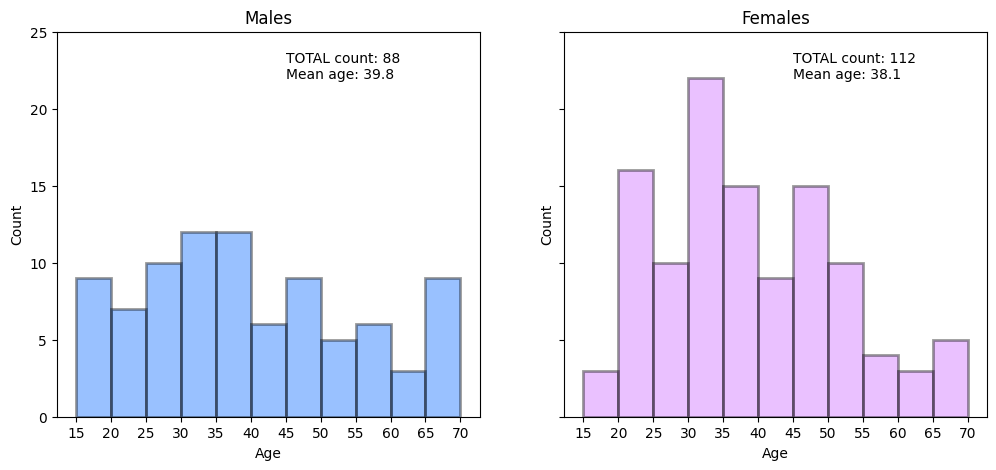

In [8]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

- average age of male customers is lightly higher than female ones (39.8 versus 38.1)
- Distribution of male age is more uniform than females
  - we can observe that the biggest age group is 30-35 years old

In [9]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


-  shows that the differences between these two groups are statistically insignificant

**Gender**

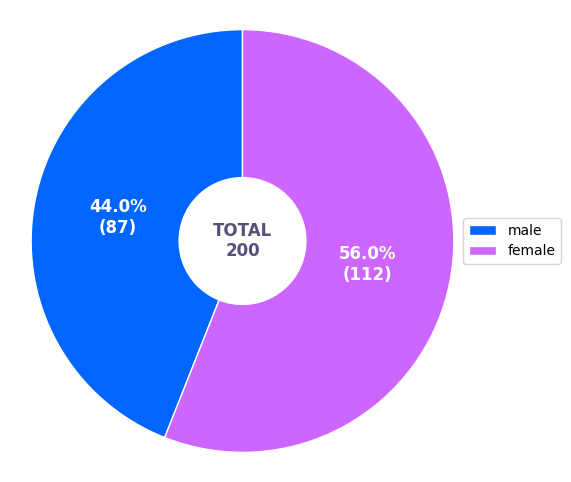

In [10]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

- slightly more female customers than male ones (112 vs. 87)
- females are 56% of total customers

**Annual Income**

<ipython-input-11-0d86fc4a2b23>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-11-0d86fc4a2b23>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bi

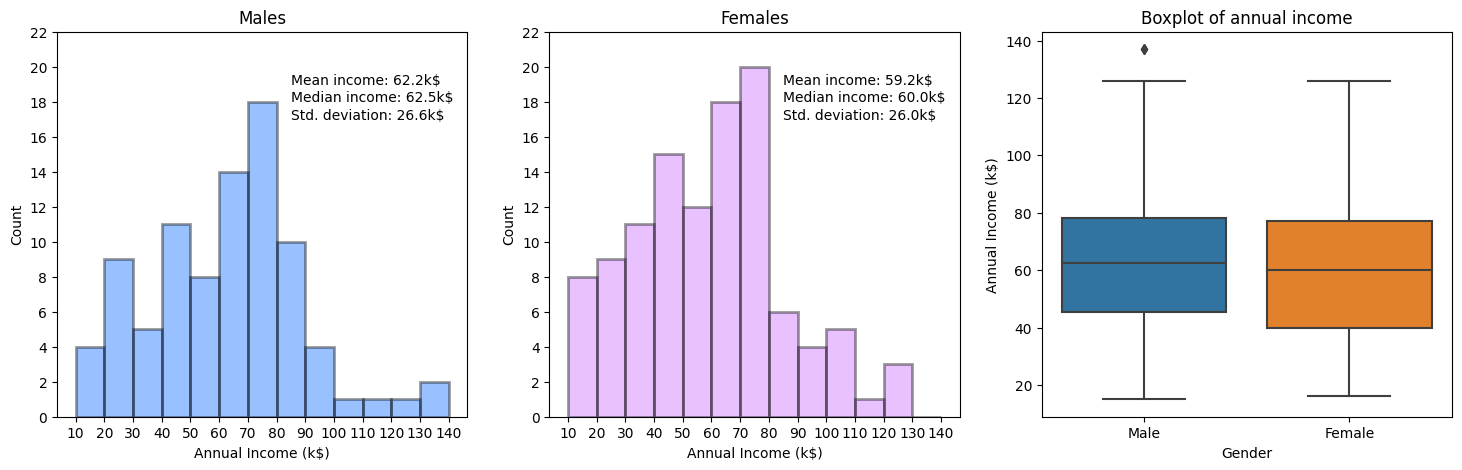

In [11]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

- Mean income of males is higher than females (62.2 vs. 59.2)
- Median income of male customers (62.5) is higher thn female ones (60)
- Standard deviation is similar for both groups
- one outlier in male group with an annual income of about 140

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


- shows that these two groups are not statistically different

**Spending Income**

<ipython-input-13-95f80557e0ae>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-13-95f80557e0ae>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

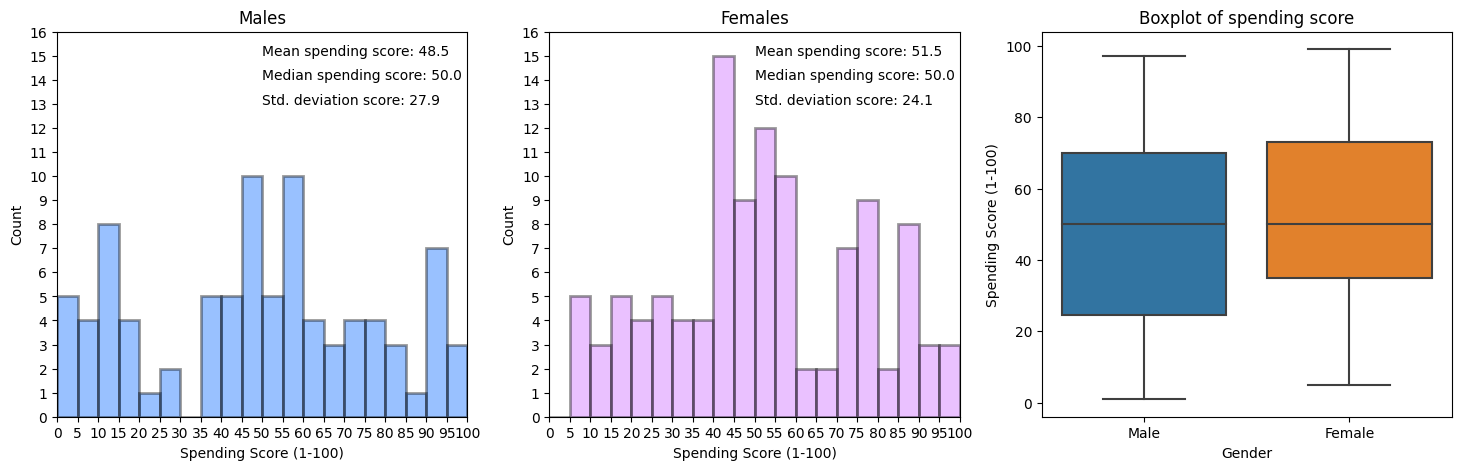

In [13]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

- A mean spending score for women (51.5) is higher than men (48.5)

In [14]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


- indicates that there is no evidence to reject the null-hypothesis
- the evidence is not so strong as in previous comparisons

**Median income for all age groups**

In [15]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

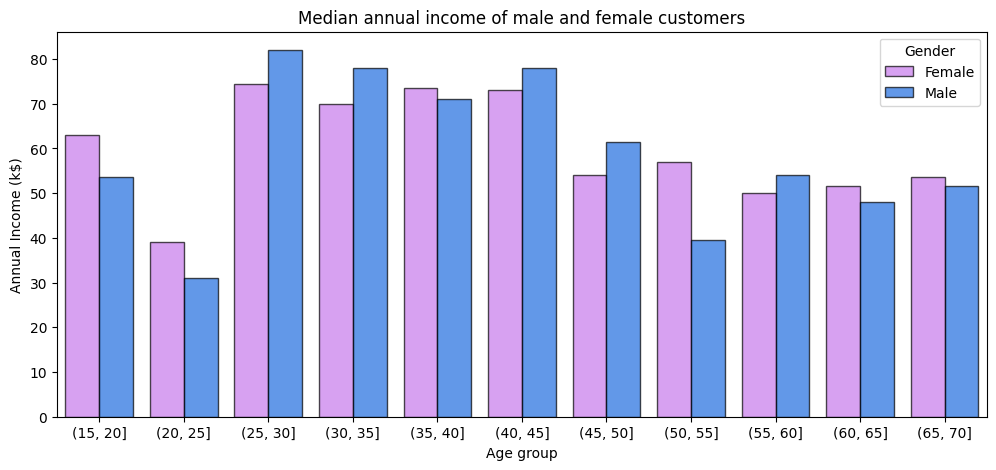

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

- most wealthy customers are in age of 25-45 years old
- biggest difference between women and men is visible in age groups 25-30 and 50-55

#### **3.2 Correlations**

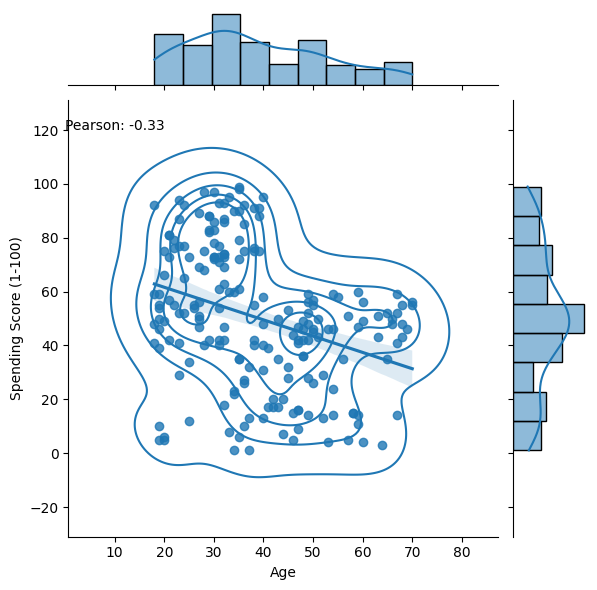

In [19]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(data=mall_data, x='Age', y='Spending Score (1-100)', kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

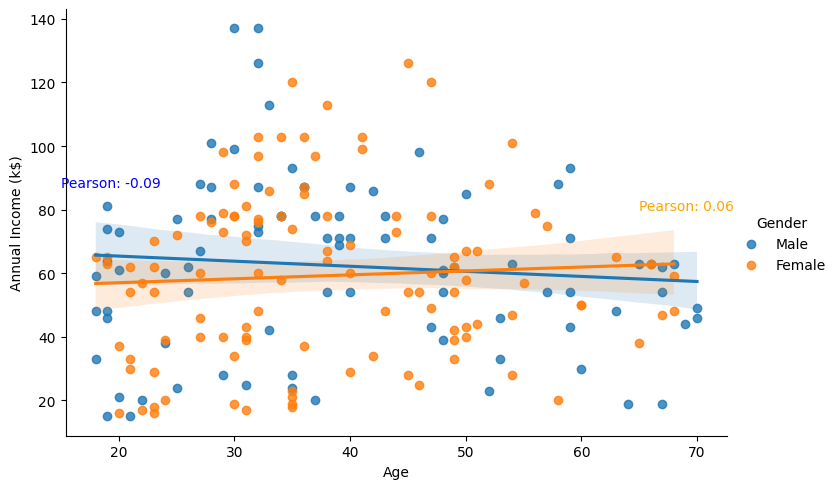

In [21]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(data=mall_data, x='Age', y='Annual Income (k$)', hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

- negligible correlation between age and annual income of customers for both sex groups

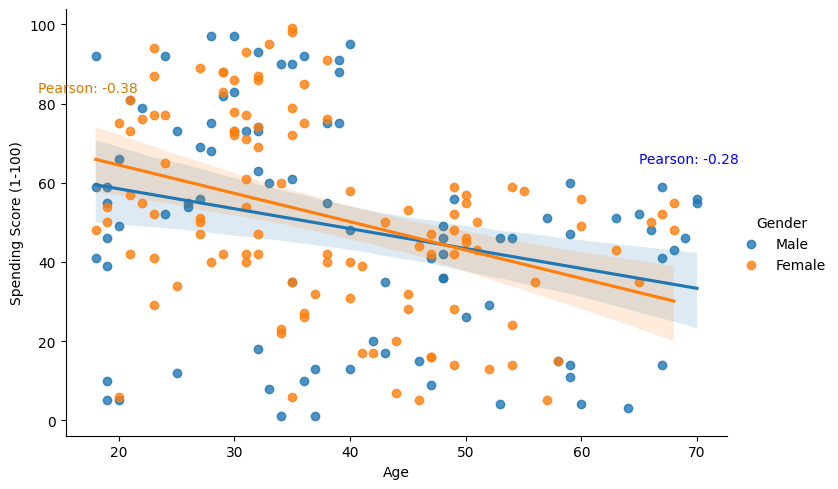

In [23]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(data=mall_data, x='Age', y='Spending Score (1-100)', hue='Gender', aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- week negative correlations (<0.5) between age and spending score for both sex groups

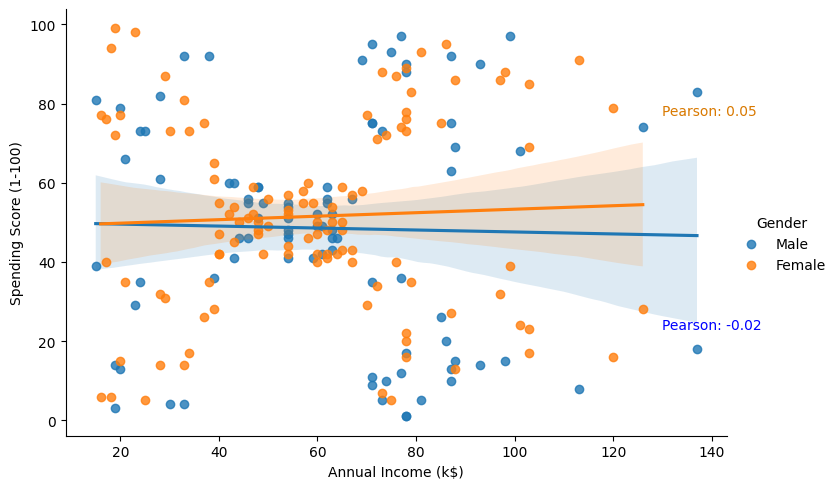

In [24]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(data=mall_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- negligible correlation between annual income and spending score of customers for both sex groups

### **4. Clustering**
- K-Means
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Affinity Propagation

#### **4.1 K-Means**

##### **4.1.1 Description**
- most well-known partitional clustering algorithm
- independently developed in many places in the 50s and 60s and gained great popularity
- ease of implementation, simplicity and many empirical successes 

**3 main steps**
- Split samples into initial groups by using seed points
  - The nearest samples to these seed point will create initial clusters
- Calculate samples distances to groups’ central points and assign the nearest samples to their cluster
- The third step is to calculate newly created (updated) cluster centroids
- repeat steps 2 and 3 until the algorithm converges

**Goal** <br/>
the goal of K-Means is to minimise the objective function (inertia) over all clusters
- a greedy algorithm and converges to the local minimum
  - computational cost of Lloyd’s K-Means algorithm is O(kn)
  - k is a number of clusters and n is a number of samples

**Advantages** <br/>
not bad when compared with other clustering algorithms
- relatively fast when groups are well isolated from each other 
  - it is likely that it converges to the global minimum
  - run the analysis for various initialisation points and choose the one with minimum resultant inertia
  - the result of clusterisation depends on the initialisation criteria
- some improvements to the algorithm solving problem of the local minima

**Main parameters**
- **Initialisation criteria**
  - initial centroids generally distant from each other increasing probability of obtaining better results
  - use a random point’s generator
  - efforts to create the most efficient seeding method for K-Means algorithm
- **Number of clusters**
  - selecting a number of clusters is the most challenging part of setting this algorithm
  - no hard mathematical criteria for this and many simplified approaches have been developed
  - one of the simplest and the most popular one is the elbow method
  - additionaly a silhouette score will be used as well
- **A distance metrics**
  - various options to calculate the distance between points
  - the most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn
  - has a drawback that it finds spherical-like groups only 
  - tends to become inflated in highly multi-dimensional analyses

##### **4.1.2 Use case - customers segmentation**

**importing K-Means from sklearn library**

In [25]:
from sklearn.cluster import KMeans 

**Numeric columns**
- For clustering only numeric columns are used
- As mentioned at the beginning the binary variable gender will not be used here

In [26]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

**Elbow method** <br/>
to find an appropriate number of clusters, the elbow method will be used
- the inertia for a number of clusters between 2 and 10 will be calculated
- rule is to choose the number of clusters where you see a kink or "an elbow" in the graph

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

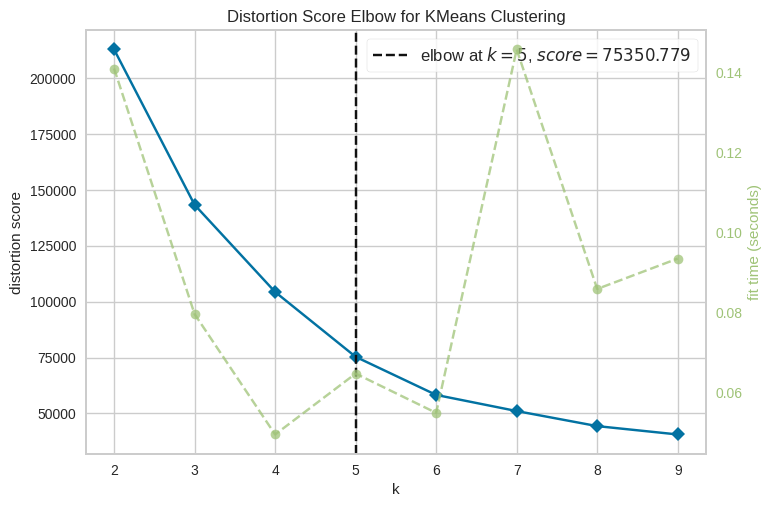

In [27]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- shows the reduction of a distortion score as the number of clusters increases
- there is no clear "elbow" visible
  - underlying algorithm suggests 5 clusters
  - choice of 5 or 6 clusters seems to be fair

**silhuette score** <br/>
to plot the silhuette score in a function of number of clusters to choose the best number of clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

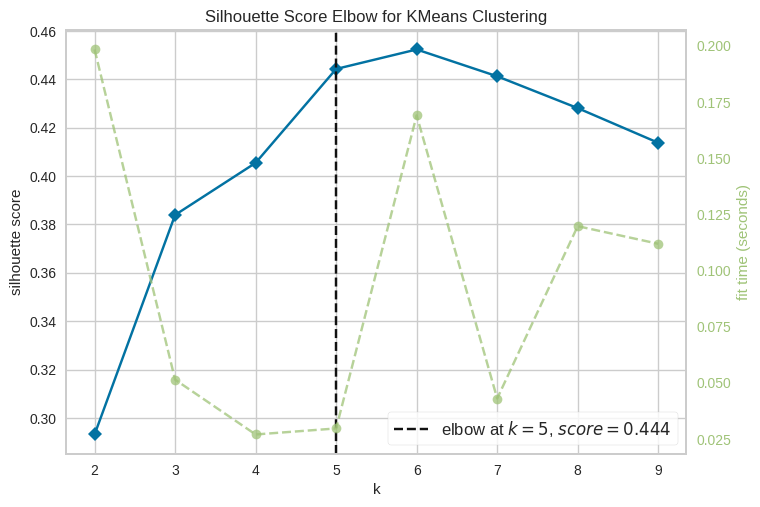

In [28]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- indicates the best options would be 5 or 6 clusters

##### **5 clusters** <br/>
K-Means algorithm generated the following 5 clusters:
- clients with **low** annual income and **high** spending score
- clients with **medium** annual income and **medium** spending score
- clients with **high** annual income and **low** spending score
- clients with **high** annual income and **high** spending score
- clients with **low** annual income and **low** spending score

In [29]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


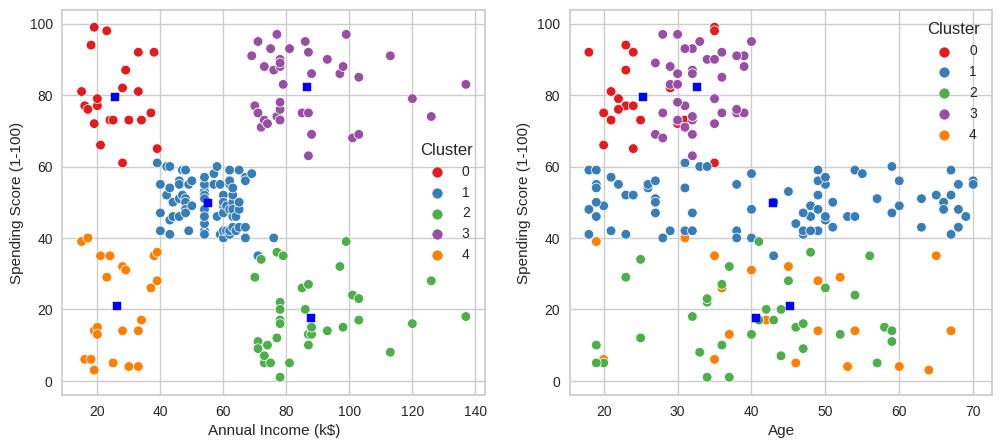

In [32]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(data=KM5_clustered, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(data=KM5_clustered, x='Age', y='Spending Score (1-100)',
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

**size of clusters**

In [33]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,22
1,80
2,36
3,39
4,23


- biggest cluster is a cluster number 1 with 79 observations
- two the smallest ones each containing 23 observations 

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

<ipython-input-34-2aceea3e6f93>:11: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
<ipython-input-34-2aceea3e6f93>:12: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
<ipython-input-34-2aceea3e6f93>:13: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])
<ipython-input-34-2aceea3e6f93>:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


<Figure size 700x700 with 0 Axes>

In [35]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

**sillhuette plot** <br/>
to check the quality of each cluster

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



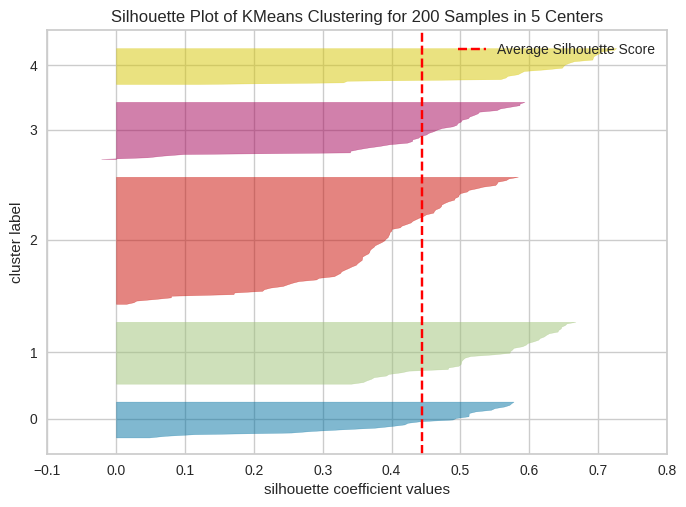

In [36]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

##### **6 clusters**
K-Means algorithm generated the following 6 clusters:
- younger clients with medium annual and medium spending score
- clients with high annual income and low spending score
- younger clients with medium annual and medium spending score
- clients with high annual income and high spending score
- clients with low annual income and low spending score
- clients with low annual income and high spending score

In [37]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



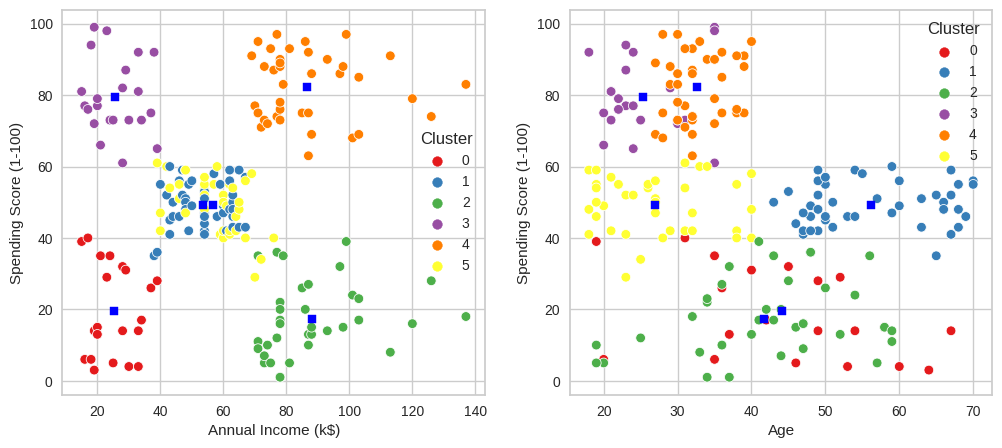

In [40]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data=KM6_clustered, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(data=KM6_clustered, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

**customer age** <br/>
no distinct groups is terms of customers age

In [41]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,21
1,45
2,35
3,22
4,39
5,38


In [42]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



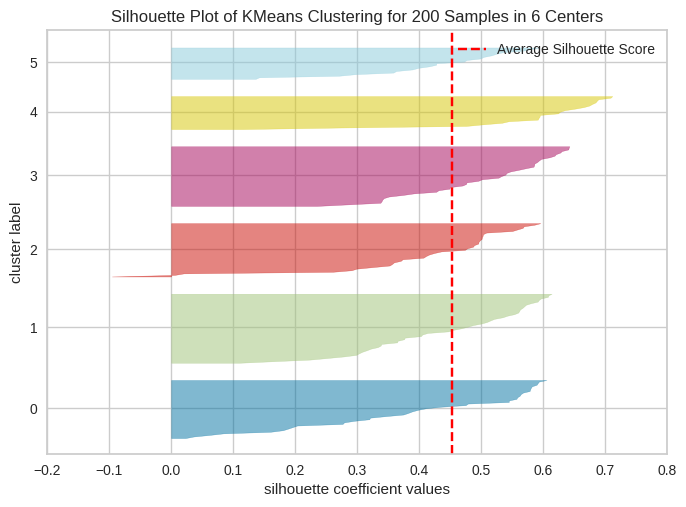

In [43]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

#### **4.2 DBSCAN**

##### **4.2.1 Description**
stands for Density-Based Spatial Clustering of Applications with Noise
- one of clustering algorithms implemented in scikit-learn library
- the core idea of DBSCAN is around concept of dense regions
  - natural clusters are composed of densely located points
  - this requires definition of “dense region”
- to do these two parameters are required for DBSCAN algorithm
  - Eps, ε: distance
  - MinPts: Minimum number of points within distance Eps
  - optionally the distance metric can be specified by a user

**Dense region** <br/>
reated by a minimum number of points within distance between Eps. Points 
- within this distance but not close to minimum number of other points are treated as “border points”
- Remaining ones are noise or outlier

**Advantages**
- finds number of clusters itself, based on eps and MinPts parameters
- able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to 
- also able to find points not fitting into any cluster – it detects outliers

**Drawback**
- High computational expense coming from a need to execute a neighbourhood query for each point
- Poorly identifies clusters with various densities

##### **4.2.2 Use case - customers segmentatoin**

**Importing DBSCAN**

In [45]:
from sklearn.cluster import DBSCAN

**Main hyperparameters** <br/>
difficult arbitrarily to say what values will work the best
- eps
- min_samples

In [46]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

**Number of generated clusters** <br/>
a heatplot shows how many clusters were generated for the respective parameters combinations

In [47]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

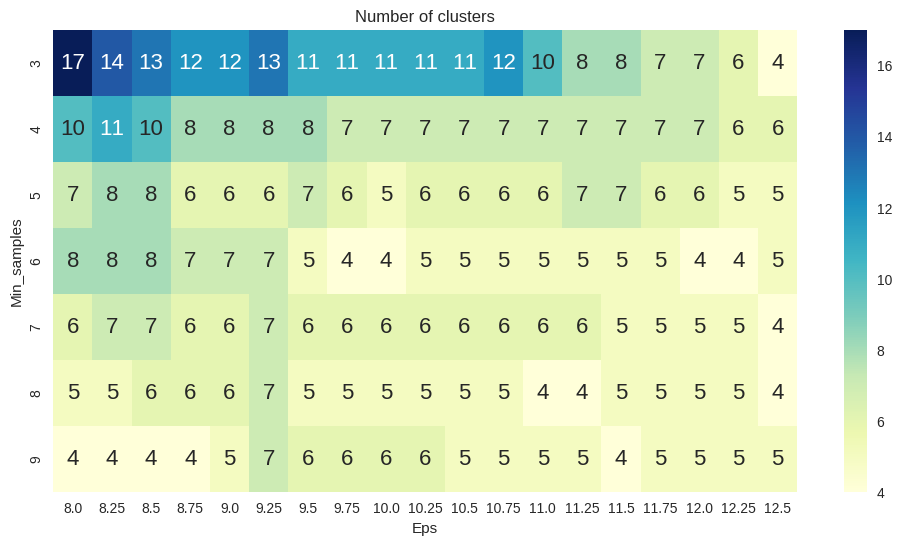

In [48]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

- the number of clusters vary from 17 to 4
- most of the combinations gives 4-7 clusters
- to decide which combination to choose I will use a metric - a silhuette score

**Silhuette score**

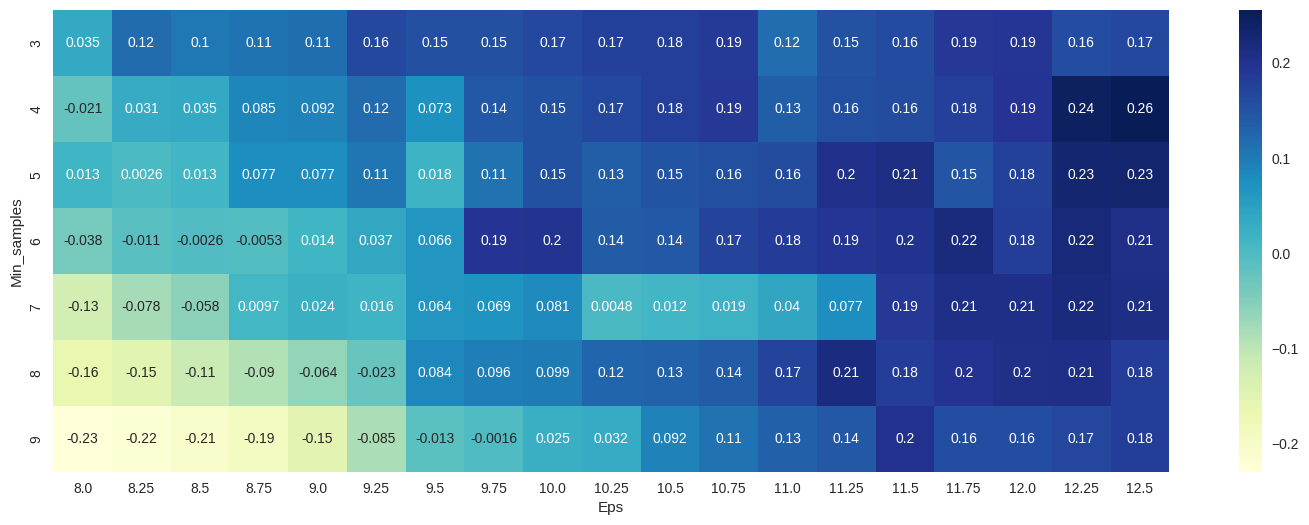

In [49]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

- global maximum is 0.26 for eps=12.5 and min_samples=4

**DBSCAN clustering**

In [50]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

**Size of clusters**

In [51]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


- created 5 clusters plus outliers cluster (-1)
- sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations
- there are 18 outliers

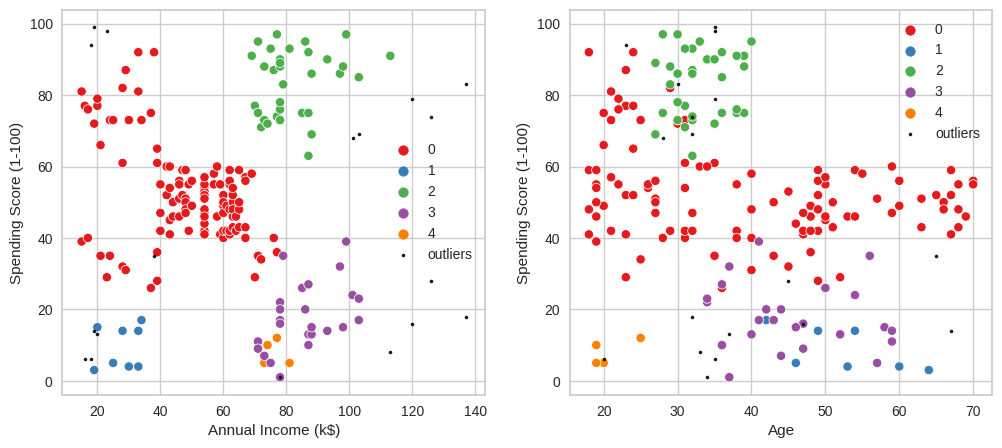

In [53]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                x='Age', y='Spending Score (1-100)',
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

#### **4.3  Affinity Propagation**

##### **4.3.1 Description**
concept of sending messages between a pair of points until it converge
- measuring how similar these two points are to each other and can they be exemplars of each other
- finds an optimum number of clusters itself
- implies very high time complexity cost of the order O(n²T)

**Advantages** <br/>
the lack of sensitivity to the initialisation criteria

**Parameters**
- Preference which is a negative number and controls how many exemplars are used
- Damping factor which prevents numerical oscillations when updating messages

##### **4.3.2 Use case - customers segmentation**

In [61]:
from sklearn.cluster import AffinityPropagation

In [62]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


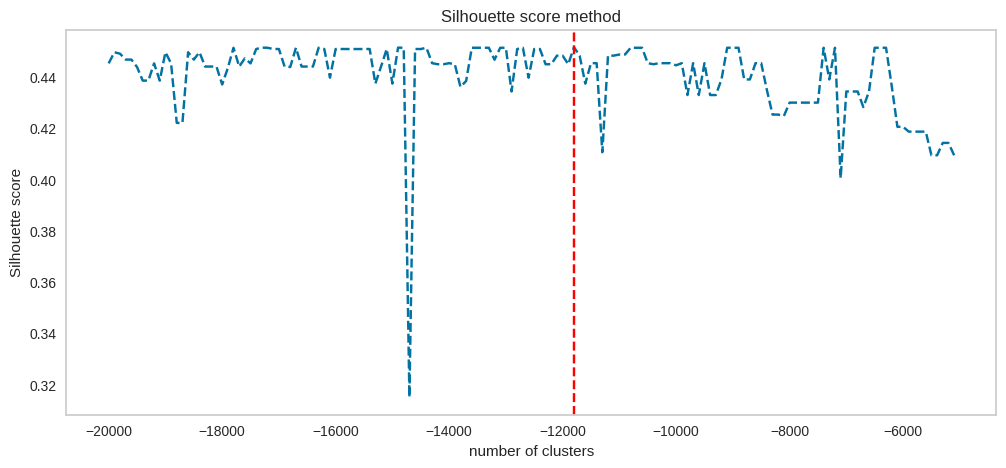

In [65]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
plt.plot(preferences, af_sil_score,linestyle='--')
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [66]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [67]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [68]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


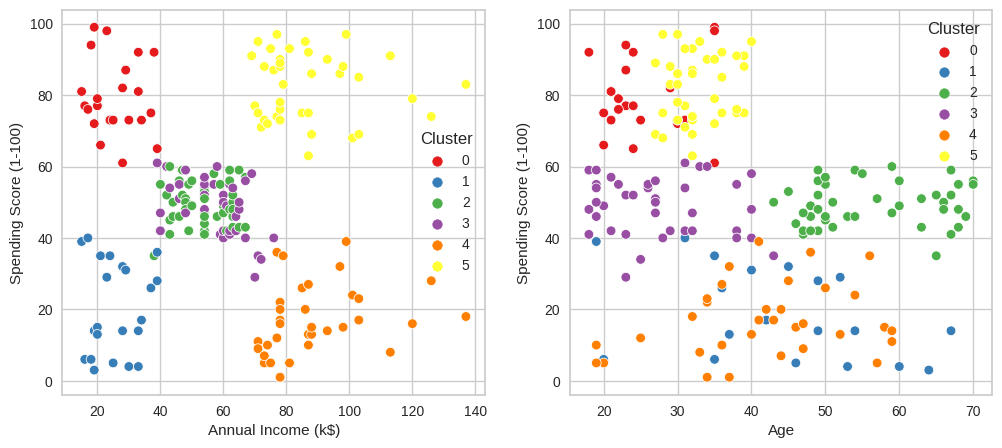

In [70]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot( data=AF_clustered, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(data=AF_clustered, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

- created relatively even-sized clusters similar to ones created by K-Means

### **5. Comparision and discussion**

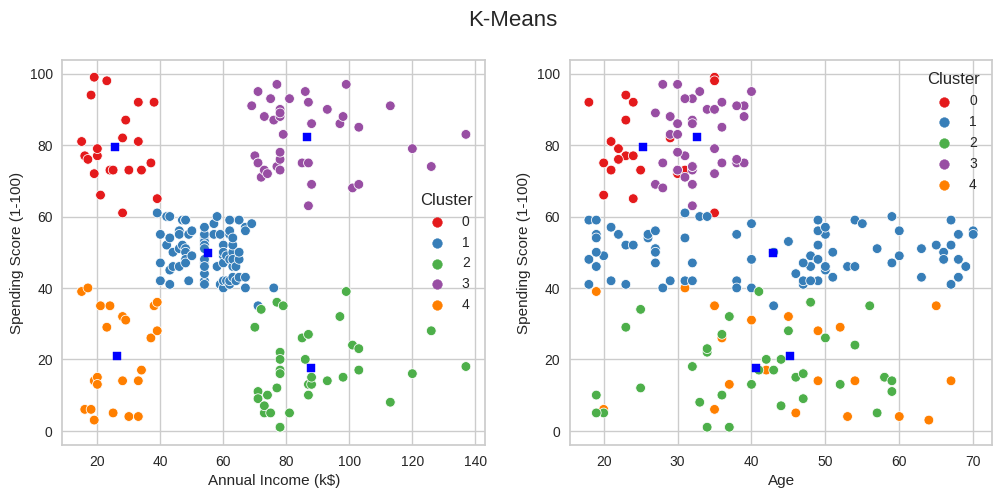

In [71]:
fig1.suptitle('K-Means', fontsize=16)
fig1

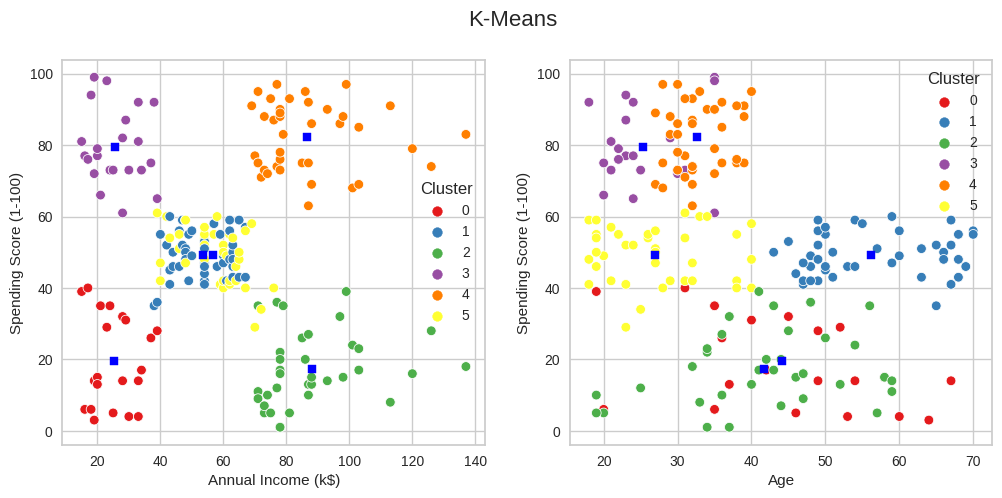

In [72]:
fig11.suptitle('K-Means', fontsize=16)
fig11

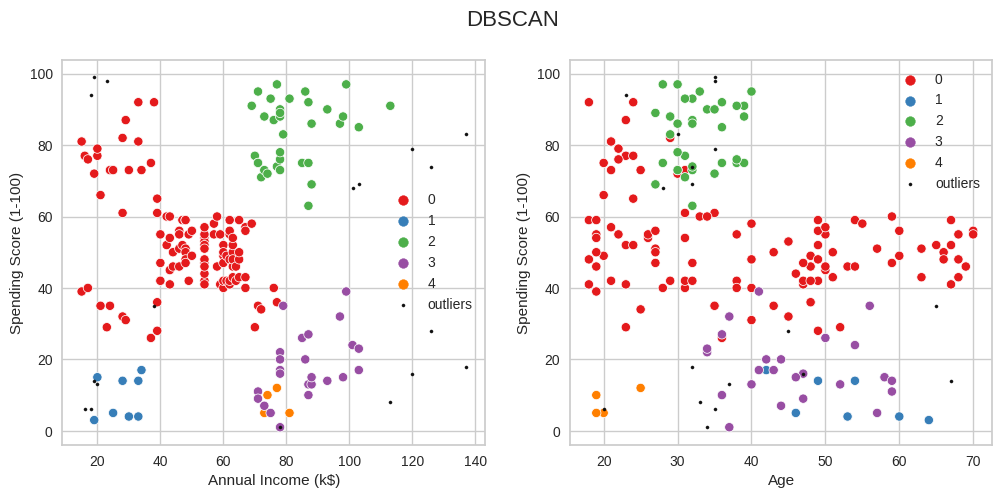

In [73]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

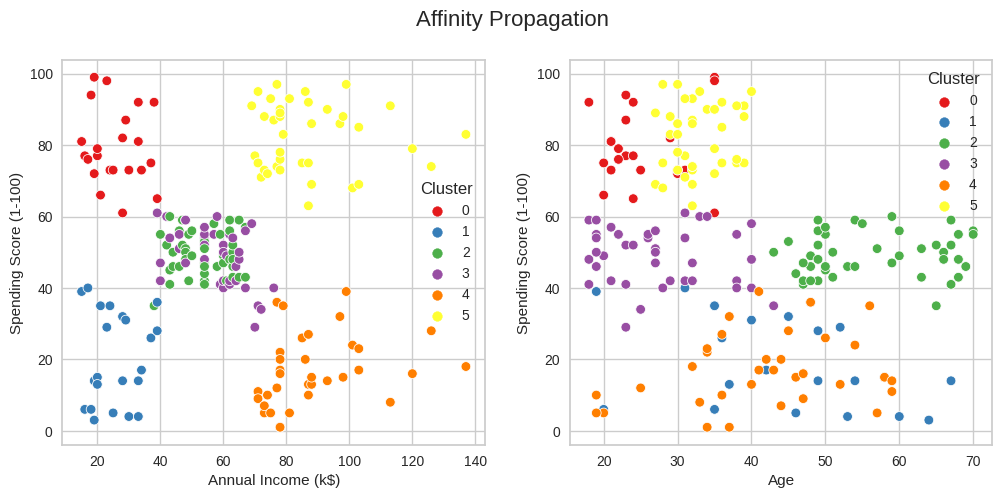

In [74]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

**size of created clusters**
- numbering of clusters is different in each method

In [75]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,21.0,112.0,22.0
1,45.0,8.0,22.0
2,35.0,34.0,44.0
3,22.0,24.0,39.0
4,39.0,4.0,34.0
5,38.0,NaN,39.0
-1,NaN,18.0,NaN


- DBSCAN failed to generate reasonable clusters
  - DBCSAN tries to find clusters based on the density of points
  - one of our clusters is less dense than others DBSCAN <br/> will produce suboptimal results by not recognising the least dense group as a cluster
- K-Means and Affinity Propagation algorithms created reasonable 6 clusters